# Backtest template

This is a template for [Jupyter Notebook](../../glossary.rst#term-Jupyter-notebook) for developing algorithmic trading strategies using
[Trading Strategy framework](https://tradingstrategy.ai/docs/index.html).

This is an empty backtest that won't do any trades, because it does not contain any trading logic.
For examples that contain strategy logic [please see the strategy examples section in the documentation](./index.rst).

✂️ ✂️ ✂️ ✂️ ✂️ ✂️ ✂️ ✂️ ✂️

## How to use this template

Copy-paste this template to your favorite Jupyter Notebook environment.
Some examples below.

<div class="alert alert-info">
    Note
    Python version 3.9 or higher is required. Google Colab is currently unsupported.
</div>


### MyBinder cloud environment

- Click *Launch Binder* at the top of this documentation page
- Save as

### Local development or Visual Studio Code

- Read instructions for [local development](../development.rst)
- Set up Visual Studio Code with Python environemnt that has *tradeexecutor* package installed
- [Download this notebook file from Github](https://github.com/tradingstrategy-ai/docs/blob/master/source/programming/strategy-examples/strategy-template.ipynb)
 and save locally
- Open the template in your Visual Studio Code

## End of instructions

The actual trading strategy code starts here.
After you have successfully run the notebook in your environment you can delete
this section and everything above this.

✂️ ✂️ ✂️ ✂️ ✂️ ✂️ ✂️ ✂️ ✂️

## Strategy parameters

In this section we set up parameters for the strategy backtest.

For available options see the documentation in relevant Python classes:

- [Strategy types](../api/execution/help/tradeexecutor.strategy.strategy_type.StrategyType.rst)
- [Blockchains](../api/client/help/tradingstrategy.chain.rst)
- [Exchanges](https://tradingstrategy.ai/trading-view/exchanges)
- [Trading pairs](https://tradingstrategy.ai/trading-view/trading-pairs)
- [Routing methods](../api/execution/help/tradeexecutor.strategy.default_routing_options.TradeRouting.rst)
- [Strategy cycles](../api/execution/help/tradeexecutor.strategy.cycle.CycleDuration.rst)
- [Candle timeframes a.k.a. candle time buckets](../api/client/help/tradingstrategy.chain.ChainId.rst)
- [Reserve currencies](../api/execution/help/tradeexecutor.strategy.reserve_currency.ReserveCurrency.rst)

Beyond the options above, we have some self-explanatory parameters like.

- Max position size (of cash, or available total equity)
- Initial cash at the start of the backtesting period
- Backtesting start and end dates

In [1]:
"""PancakeSwap v2 momentum strategy build on the top of the new trading framework.

This is "alpha model" strategy that predicts the alpha (price increase)
of multiple tokens based on their past behavior.
"""

import datetime
import enum
from typing import Dict, List, Optional, Counter

import pandas as pd

from tradeexecutor.ethereum.routing_data import get_pancake_default_routing_parameters
from tradeexecutor.strategy.pandas_trader.rebalance import rebalance_portfolio, normalise_weights, equal_weight_portfolio
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.utils.price import is_legit_price_value
from tradingstrategy.chain import ChainId
from tradingstrategy.liquidity import LiquidityDataUnavailable
from tradingstrategy.pair import DEXPair
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.universe import Universe

from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.state.state import State
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.strategy_type import StrategyType
from tradeexecutor.state.visualisation import Visualisation, PlotKind
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.strategy.reserve_currency import ReserveCurrency
from tradeexecutor.strategy.default_routing_options import TradeRouting
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_all_data, \
    translate_trading_pair
from tradingstrategy.client import Client

# Tell what trade execution engine version this strategy needs to use
trading_strategy_engine_version = "0.1"

# What kind of strategy we are running.
# This tells we are going to use
trading_strategy_type = StrategyType.alpha_model

# How our trades are routed.
# PancakeSwap basic routing supports two way trades with BUSD
# and three way trades with BUSD-BNB hop.
trade_routing = TradeRouting.pancakeswap_busd

# How often the strategy performs the decide_trades cycle.
# We do it for every 16h.
trading_strategy_cycle = CycleDuration.cycle_1d

# Strategy keeps its cash in BUSD
reserve_currency = ReserveCurrency.busd

# Time bucket for our candles
candle_time_bucket = TimeBucket.d1

# Which chain we are trading
chain_id = ChainId.bsc

# Which exchange we are trading on.
exchange_slug = "pancakeswap-v2"

# Use 4h candles for trading
candle_time_frame = TimeBucket.d1

# How far back we look the momentum.
momentum_lookback_period = pd.Timedelta(hours=48)

# What is the liquidity risk we are willing to accept (USD)
risk_min_liquidity_threshold = 500_000

class RiskAssessment(enum.Enum):
    """Potential risk flags for a trading pair."""
    accepted_risk = "risk_accepted"
    pair_info_missing = "risk_pair_info_missing"
    blacklisted = "risk_blacklisted"
    token_tax = "risk_token_tax"
    lack_of_liquidity = "risk_lack_of_liquidity"
    bad_price_units = "risk_bad_price_units"


def assess_risk(state: State, pair: DEXPair, price: float, liquidity: float) -> RiskAssessment:
    """Do the risk check for the trading pair if it accepted to our alpha model.

    - There needs to be enough liquidity

    - The price unit must look sensible
    """

    executor_pair = translate_trading_pair(pair)

    # Skip any trading pair with machine generated tokens
    # or otherwise partial looking info
    if not executor_pair.has_complete_info():
        return RiskAssessment.pair_info_missing

    # Wast this pair blacklisted earlier by the strategy itself
    if not state.is_good_pair(executor_pair):
        return RiskAssessment.blacklisted

    # This token is marked as not tradeable, so we don't touch it
    if (pair.buy_tax != 0) or (pair.sell_tax != 0) or (pair.transfer_tax != 0):
        return RiskAssessment.token_tax

    # The pair does not have enough liquidity for us to enter
    if liquidity < risk_min_liquidity_threshold:
        return RiskAssessment.lack_of_liquidity

    # The price value does not seem legit
    # and might have floating point issues
    if is_legit_price_value(price):
        return RiskAssessment.bad_price_units

    return RiskAssessment.accepted_risk


def filter_duplicate_base_tokens(self, alpha_signals: Counter, debug_data: dict) -> Counter:
    """Filter duplicate alpha signals for trading pairs sharing the same base token.

    This is because on DEX markets, the base token may trade with several quote tokens.

    For example, we can end up holding BNB by buying
    - WBNB-BUSD
    - WBNB-USDT

    For the portfolio, it does not matter which route we ended up buying the token
    (although this matters for the price impact).

    We use the already resolved pair data to check for the duplicates.
    We'll just filter out the second entry (worse alpha).
    """
    accumulated_quote_tokens = set()
    filtered_alpha = Counter()
    for pair_id, alpha in alpha_signals.most_common():
        pair: DEXPair = debug_data[pair_id]["pair"]
        base_token = pair.base_token_symbol
        if base_token in accumulated_quote_tokens:
            continue
        filtered_alpha[pair_id] = alpha
        accumulated_quote_tokens.add(base_token)
    return filtered_alpha



def decide_trades(
        timestamp: pd.Timestamp,
        universe: Universe,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:


    position_manager = PositionManager(timestamp, universe, state, pricing_model)


    # pair id -> how much alpha it has
    alpha_signals = Counter()

    # The time range end is the current candle
    # The time range start is 2 * 4 hours back, and turn the range
    # exclusive instead of inclusive
    start = timestamp - momentum_lookback_period - datetime.timedelta(minutes=59)
    end = timestamp

    candle_universe = universe.candles
    pair_universe = universe.pairs
    liquidity_universe = universe.liquidity
    candle_data = candle_universe.iterate_samples_by_pair_range(start, end)

    # Track number of problematic trading pairs
    # for this trade cycle
    issue_tracker = Counter({
        "lacks_open_and_close_in_momentum_window": 0,
        "liquidity_information_missing": 0,
        "non_positive_momentum": 0,
        "accepted_alpha_candidates": 0,
    })

    # Expose pair specific debug data to the
    # research
    pair_debug_data = {}

    # Iterate over all candles for all pairs in this timestamp (ts)
    for pair_id, pair_df in candle_data:

        first_candle = pair_df.iloc[0]
        last_candle = pair_df.iloc[-1]

        # How many candles we are going to evaluate
        candle_count = len(pair_df)

        pair_momentum_window = last_candle["timestamp"] - first_candle["timestamp"]
        if pair_momentum_window < momentum_lookback_period:
            # This trading pair does not have data for this window,
            # ignore the pair and mark it as a problem
            issue_tracker["lacks_open_and_close_in_momentum_window"] += 1
            continue

        open = first_candle["open"]  # QStrader data frames are using capitalised version of OHLCV core variables
        close = last_candle["close"]  # QStrader data frames are using capitalised version of OHLCV core variables

        pair = pair_universe.get_pair_by_id(pair_id)

        if is_legit_price_value(close):
            # This trading pair is too funny that we do not want to play with it
            issue_tracker["price_unit_problematic"] += 1
            continue

        # We define momentum as how many % the trading pair price gained during
        # the momentum window
        momentum = (close - open) / open
        momentum = max(0, momentum)

        # This pair has positive momentum, check if it has enough available liquidity
        available_liquidity_for_pair = 0
        if momentum > 0:

            # Check for the liquidity requirement
            try:
                available_liquidity_for_pair = liquidity_universe.get_closest_liquidity(pair_id, timestamp)
            except LiquidityDataUnavailable as e:
                # There might be holes in the data, because BSC network not syncing properly,
                # BSC blockchain was halted or because BSC nodes themselves had crashed.
                # In this case, we just assume the liquidity was zero and don't backtest.
                issue_tracker["liquidity_information_missing"] += 1

        else:
            issue_tracker["non_positive_momentum"] += 1
            continue

        risk = assess_risk(state, pair, close, available_liquidity_for_pair)

        if risk == RiskAssessment.accepted_risk:
            # Do candle check only after we know the pair is "good" liquidity wise
            # and should have candles
            candle_count = len(pair_df)
            alpha_signals[pair_id] = momentum

            issue_tracker["accepted_alpha_candidates"] += 1
        else:
            # Delette pair from the alpha set because of observed risk
            del alpha_signals[pair_id]

            # Track the number of risk issues we have detectd in this cycle
            issue_tracker[str(risk.value)] += 1

        # Extra debug details are available for pairs for which a buy decision can be made
        pair_debug_data[pair_id] = {
            "pair": pair,
            "open": open,
            "close": close,
            "momentum": momentum,
            "liquidity": available_liquidity_for_pair,
            "candle_count": candle_count,
        }

#    max_assets_in_portfolio = int(len(alpha_signals) / 20)
    max_assets_in_portfolio = 100
    alpha_signals = alpha_signals.most_common(max_assets_in_portfolio)

    weights = normalise_weights(equal_weight_portfolio(alpha_signals))

    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity()

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    trades = rebalance_portfolio(
        position_manager,
        weights,
        portfolio_target_value,
    )

    return trades


def create_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions = None,
) -> TradingStrategyUniverse:
    """Creates the trading universe where the strategy trades.

    We reload candle data for each cycle.
    """

    # Load all datas we can get for our candle time bucket
    dataset = load_all_data(
        client,
        candle_time_bucket,
        execution_context,
        universe_options,
        )

    routing_parameters = get_pancake_default_routing_parameters(ReserveCurrency.busd)

    universe = TradingStrategyUniverse.create_multipair_universe(
        dataset,
        [chain_id],
        [exchange_slug],
        quote_tokens=routing_parameters["quote_token_addresses"],
        reserve_token=routing_parameters["reserve_token_address"],
        factory_router_map=routing_parameters["factory_router_map"],
    )

    return universe


## Strategy logic

The strategy logic is in `decide_trades()` Python function.

- This function is called for each [strategy cycle](../../running/architecture.rst#strategy cycle).
- The return value of the function is a list of trades that the strategy does for the cycle.
- The logic function takes inputs:
  * Timestamp is the time of the strategy cycle. This is never real-time clock, but always rounded to the cycle time.
  * The function takes the strategy trading universe as an input. This is OHLCV and liquidity data for chosen trading pairs. The additional input includes the current `State` of the strategy execution.
  * The function also receives the current `PricingModel` as the input. The pricing model estimates how much it will cost us to open or close positions, in the terms of price impact and transaction fees.
  * The function also receives `cycle_debug_data` that strategy developers can use to
- The function constructs `PositionManager` helper class to generate trades for different actions (open position, close position, close all positions). You can also use PositionManager to query open positions.
- The strategy can further visualise the indicators it uses using `visualisation` instance that is part of the state. This is especially useful during backtesting when one is iterating through different trading ideas and want to see how they behave.

If you do not add any logic, the backtest results section will plot the price action
for the backtest duration and no positions or trades are made.


## Trading universe

Trading universe tells us what assets our strategy will trade.

- Blockchains it trades on
- Exchanges it trades on
- List of allowed trading pairs

In this example, we create a trading universe that contains only a single predefined trading pair.

Unless you want to have multipair trading strategy, you do not need to change this function, as it only reads input from *Strategy parameters* section above.

## Market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

When this notebook is run, you will receive a prompt or a dialog box to enter your API key.
After entering the API key once, it is saved on your notebook system in your home folder.

In [2]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /home/vscode/.tradingstrategy


## Running backtest

In this section, the backtest is run using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.
- The trade execution engine will download the necessary datasets to run the backtest.
  The datasets may be large, several gigabytes.

Unless you want to customize how backtests are run, you do not need to change this section, as it is only using parameters defined in *Strategy parameters* section above.

In [3]:
import logging
import datetime

from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.cli.log import setup_custom_log_levels

state, universe, debug_dump = run_backtest_inline(
    name="momentum1",
    start_at=datetime.datetime(2022, 1, 1),
    end_at=datetime.datetime(2022, 7, 1),
    client=client,
    cycle_duration=trading_strategy_cycle,
    decide_trades=decide_trades,
    create_trading_universe=create_trading_universe,
    initial_deposit=1_000_000,
    reserve_currency=reserve_currency,
    trade_routing=trade_routing,
    log_level=logging.INFO,
)


  0%|          | 0/2678400 [00:00<?, ?it/s]

## Backtest results

In this section, we examine and visualise the performance of the trading strategy
based on its backtest results.

- We read `state` object that contains all backtesting positions and trades created during the backtest run
- Based on these trades, we create various charts ana analysis to understand the strategy performance

For analysis options see *strategy performance analysis* section in the documentatio.

### Trade and position count

We print out how many (if any) positions and trades was taken by the strategy.

In [ ]:
print(f"Backtesting complete")
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Backtesting complete
Positions taken: 655
Trades made: 2383


### Price and trade chart

We plot out a chart that shows
- The price action
- Any technical indicators we used and added to the `visualisation`
- When the strategy made buys or sells

In [ ]:
from tradeexecutor.visual.single_pair import visualise_single_pair

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=datetime.datetime(2022, 1, 1),
    end_at=datetime.datetime(2022, 2, 1),
    )

figure.show()

AssertionError: visualise_single_pair() can be only used for a trading universe with a single pair

### Portfolio performance benchmark

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold the underlying trading pair base asset

You can add more complex benchmarking, or different asset and stratey benchmarks here.

In [ ]:
close = universe.universe.candles.get_single_pair_data()["close"]

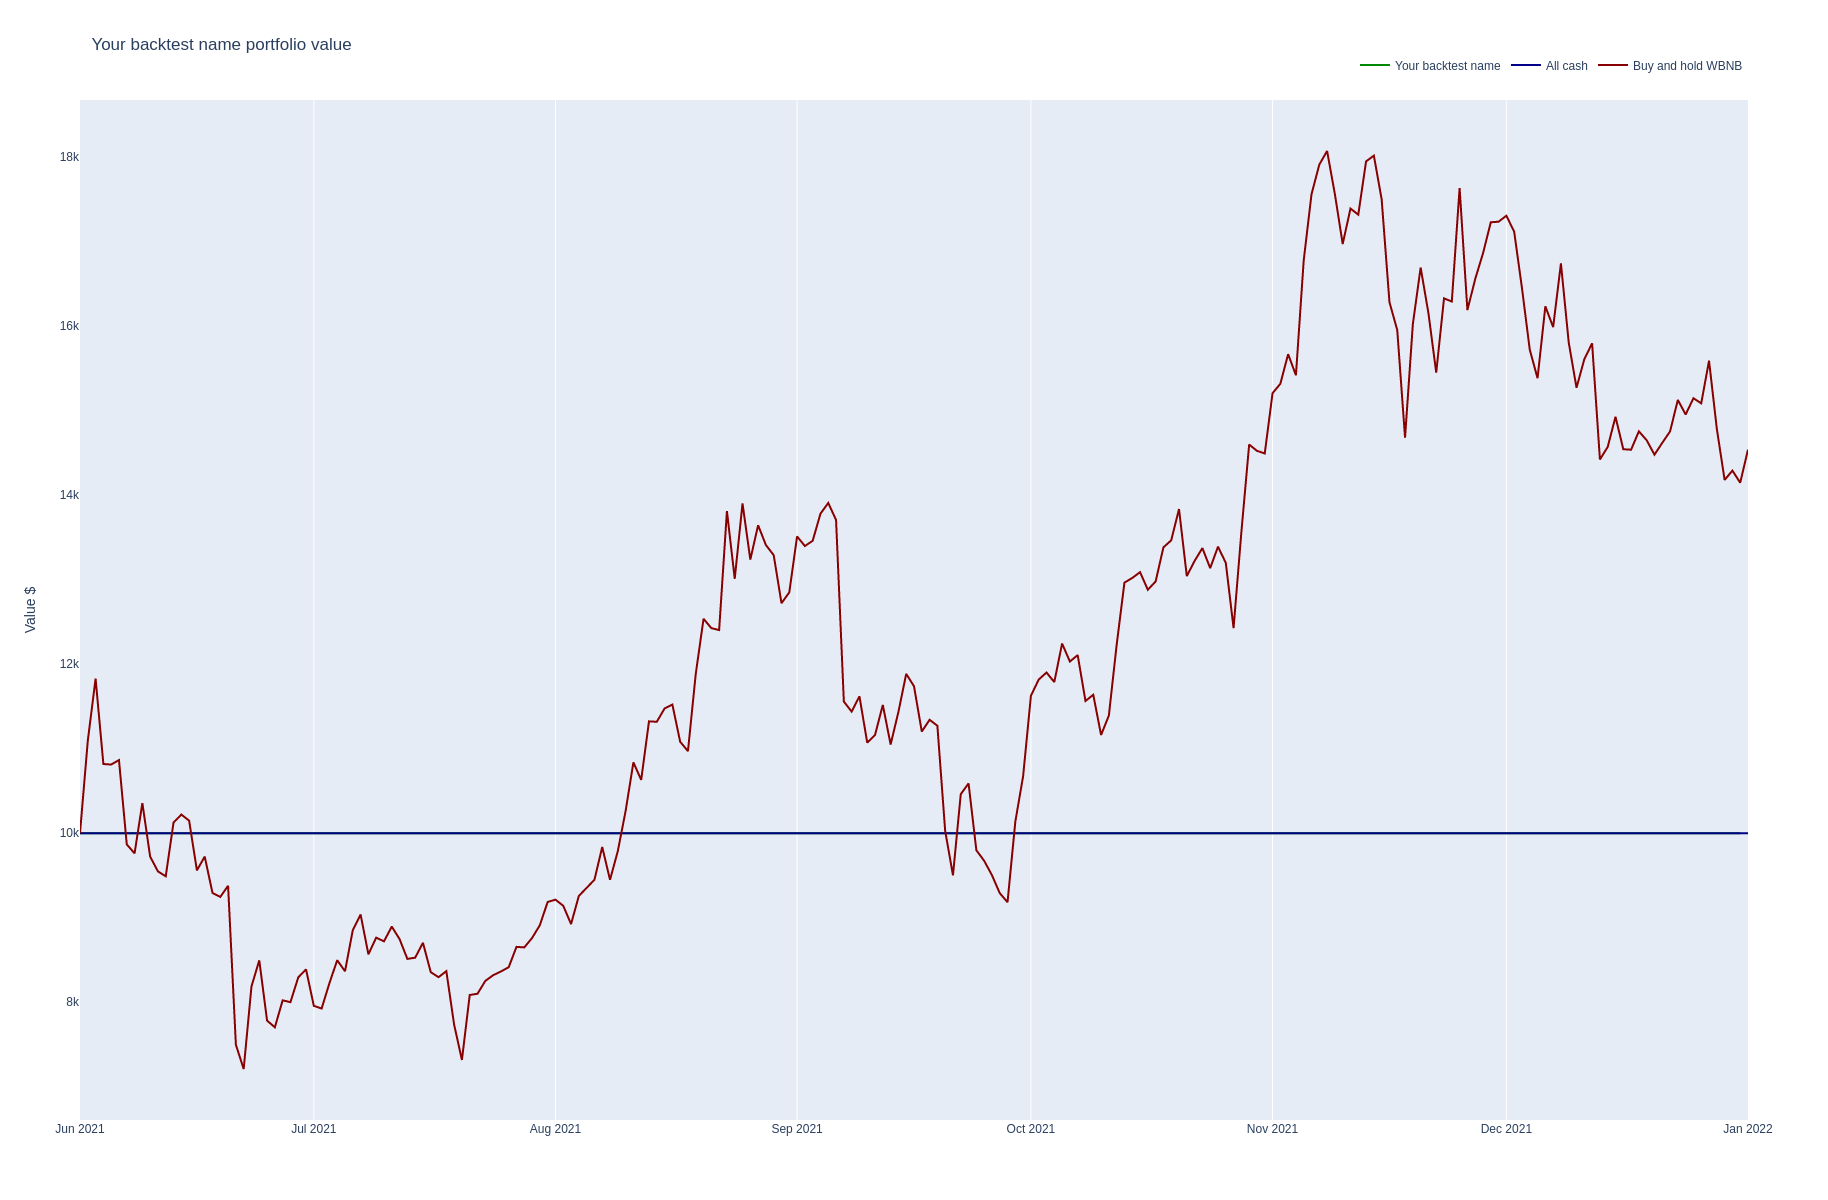

In [ ]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=start_at,
    end_at=end_at
)

fig.show()

### Trading success

Here we calculate statistics on how well the trades made by our strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [ ]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Performance summary numbers

Print out overview numbers of the strategy performance.



In [ ]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

,0
Trading period length,30 days
Return %,79.26%
Annualised return %,964.30%
Cash at start,"$1,000,000.00"
Value at end,"$3,176,465.22"
Trade win percent,65.93%
Total trades done,587
Won trades,387
Lost trades,200
Stop losses triggered,0


### Position and trade timeline

Display all positions and how much profit they made.

In [ ]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)


if len(expanded_timeline) > 0:
    # Do not truncate the row output
    with pd.option_context("display.max_row", None):
        display(apply_styles(expanded_timeline))


Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so this method might produce wrong result
Position has %d trades so

Remarks,Opened at,Duration,Exchange,Base asset,Quote asset,Position max value,PnL USD,PnL %,Open mid price USD,Close mid price USD,Trade count,LP fees
,2022-01-01,2 days,PancakeSwap v2,JADE,BUSD,"$10,000.00","$-4,779.73",-36.57%,$56.575710,$33.097282,3,$0.00
,2022-01-01,2 days,PancakeSwap v2,MRHB,USDT,"$10,287.37","$-1,860.60",-15.32%,$0.132948,$0.108821,3,$0.00
,2022-01-01,1 days,PancakeSwap v2,TIME,USDT,"$10,000.00",$-329.62,-3.30%,$0.026332,$0.025591,2,$0.00
,2022-01-01,2 days,PancakeSwap v2,CMX,USDT,"$10,000.06",$-526.27,-5.00%,$20.605658,$19.652822,3,$0.00
,2022-01-01,2 days,PancakeSwap v2,SXP,WBNB,"$10,000.00",$318.37,3.18%,$2.040882,$2.105888,3,$0.00
,2022-01-01,3 days,PancakeSwap v2,BTH,BUSD,"$14,627.05","$2,287.41",17.61%,$0.161407,$0.200794,4,$0.00
,2022-01-01,3 days,PancakeSwap v2,SEA,WBNB,"$12,791.60","$1,519.75",10.92%,$0.892957,$1.057423,4,$0.00
,2022-01-01,4 days,PancakeSwap v2,MLT,WBNB,"$18,702.33","$5,013.26",30.57%,$0.247990,$0.373094,5,$0.00
,2022-01-01,2 days,PancakeSwap v2,DARK,BUSD,"$10,000.00","$-1,272.17",-11.83%,$0.863115,$0.762391,3,$0.00
,2022-01-01,2 days,PancakeSwap v2,GAME,BUSD,"$10,052.97",$-848.20,-7.78%,$1.888873,$1.741711,3,$0.00


## Finish

This is the last section of the strategy backtest notebook.

You can add any further analysis for your backtest here.

We print out a comment to signal the notebook finished the execution successfully.

In [ ]:
print("All ok")

All ok
